# Cybersecurity: Suspicious Web Threat Interactions
### Source: *[Kaggle](https://www.kaggle.com/datasets/jancsg/cybersecurity-suspicious-web-threat-interactions)*
---

## About Dataset
This dataset contains web traffic records collected through AWS CloudWatch, aimed at detecting suspicious activities and potential attack attempts. The data was generated by monitoring traffic to a production web server, using various detection rules to identify anomalous patterns.

## Context
In today's cloud environments, cybersecurity is more crucial than ever. The ability to detect and respond to threats in real time can protect organizations from significant consequences. This dataset provides a view of web traffic that has been labeled as suspicious, offering a valuable resource for developers, data scientists, and security experts to enhance threat detection techniques.

## Dataset Content
Each entry in the dataset represents a stream of traffic to a web server, including the following columns:

`bytes_in`: Bytes received by the server.

`bytes_out`: Bytes sent from the server.

`creation_time`: Timestamp of when the record was created.

`end_time`: Timestamp of when the connection ended.

`src_ip`: Source IP address.

`src_ip_country_code`: Country code of the source IP.

`protocol`: Protocol used in the connection.

`response.code`: HTTP response code.

`dst_port`: Destination port on the server.

`dst_ip`: Destination IP address.

`rule_names`: Name of the rule that identified the traffic as suspicious.

`observation_name`: Observations associated with the traffic.

`source.meta`: Metadata related to the source.

`source.name`: Name of the traffic source.

`time`: Timestamp of the detected event.

`detection_types`: Type of detection applied.

## Methodology
This project follows a systematic approach:

> **Baseline Model**: A simple statistical detector using the Interquartile Range (IQR) method establishes the minimum performance threshold. This baseline identifies extreme outliers based on traffic volume (bytes transferred).

> **Advanced Model**: An Isolation Forest algorithm captures multidimensional patterns that the baseline cannot detect, considering multiple features simultaneously (traffic volume, connection duration, time of day, geographic origin).

> **Comparative Analysis**: Both models are evaluated and compared using clustering quality metrics (Silhouette Score) to assess separation between normal and critical threats.

### Imports
---

In [1]:
# System
import os, sys
from pathlib import Path

# Custom scripts
from scripts.kaggle_setup import *
from scripts.df_summary import print_dataframe_summary
from scripts.baseline_model import TrafficAnomalyBaseline

# Analysis
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib_venn import venn2
import seaborn as sns

# Modeling
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.metrics import silhouette_score, silhouette_samples
import joblib

### Dataset
---

In [2]:
df = pd.read_csv('dataset/CloudWatch_Traffic_Web_Attack.csv')
display(df.head())
print("-" * 80)
print(f"Duplicated rows: {df.duplicated().sum()}")

,bytes_in,bytes_out,creation_time,end_time,src_ip,src_ip_country_code,protocol,response.code,dst_port,dst_ip,rule_names,observation_name,source.meta,source.name,time,detection_types
0,5602,12990,2024-04-25T23:00:00Z,2024-04-25T23:10:00Z,147.161.161.82,AE,HTTPS,200,443,10.138.69.97,Suspicious Web Traffic,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-25T23:00:00Z,waf_rule
1,30912,18186,2024-04-25T23:00:00Z,2024-04-25T23:10:00Z,165.225.33.6,US,HTTPS,200,443,10.138.69.97,Suspicious Web Traffic,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-25T23:00:00Z,waf_rule
2,28506,13468,2024-04-25T23:00:00Z,2024-04-25T23:10:00Z,165.225.212.255,CA,HTTPS,200,443,10.138.69.97,Suspicious Web Traffic,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-25T23:00:00Z,waf_rule
3,30546,14278,2024-04-25T23:00:00Z,2024-04-25T23:10:00Z,136.226.64.114,US,HTTPS,200,443,10.138.69.97,Suspicious Web Traffic,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-25T23:00:00Z,waf_rule
4,6526,13892,2024-04-25T23:00:00Z,2024-04-25T23:10:00Z,165.225.240.79,NL,HTTPS,200,443,10.138.69.97,Suspicious Web Traffic,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-25T23:00:00Z,waf_rule


--------------------------------------------------------------------------------
Duplicated rows: 0


### Feature Engineering
---
* From *`time`* feature: *`hour`*

* *`duration_seconds`*: *`end_time` - `creation_time`*

* *`bytes_ratio`*: $\LARGE r = \frac{b_{\text{out}}}{b_{\text{in}} + 1}$

In [3]:
date_cols = ['creation_time', 'end_time', 'time']
for var in date_cols:
    df[var] = pd.to_datetime(df[var])
    
df.columns = df.columns.str.replace('.', '_', regex=False)

df['duration_seconds'] = (df['end_time'] - df['creation_time']).dt.total_seconds()
df['hour'] = df['time'].dt.hour
df['bytes_ratio'] = df['bytes_out'] / (df['bytes_in'] + 1) # +1 to prevent div by 0

display(df[[
    'creation_time', 'end_time', 'duration_seconds', 
    'time', 'hour', 'bytes_ratio'
]].head())

,creation_time,end_time,duration_seconds,time,hour,bytes_ratio
0,2024-04-25 23:00:00+00:00,2024-04-25 23:10:00+00:00,600.0,2024-04-25 23:00:00+00:00,23,2.318401
1,2024-04-25 23:00:00+00:00,2024-04-25 23:10:00+00:00,600.0,2024-04-25 23:00:00+00:00,23,0.588296
2,2024-04-25 23:00:00+00:00,2024-04-25 23:10:00+00:00,600.0,2024-04-25 23:00:00+00:00,23,0.472445
3,2024-04-25 23:00:00+00:00,2024-04-25 23:10:00+00:00,600.0,2024-04-25 23:00:00+00:00,23,0.467411
4,2024-04-25 23:00:00+00:00,2024-04-25 23:10:00+00:00,600.0,2024-04-25 23:00:00+00:00,23,2.128390


In [4]:
print(df['duration_seconds'].value_counts())

duration_seconds
600.0    282
Name: count, dtype: int64


In [5]:
print_dataframe_summary(df, 'Suspicious Web Threat Interactions')

           COMPREHENSIVE SUMMARY: Suspicious Web Threat Interactions            

────────────────────────────────────────────────────────────────────────────────
📊 BASIC INFORMATION
────────────────────────────────────────────────────────────────────────────────
Shape: 282 rows × 19 columns
Memory Usage: 0.17 MB
Duplicate Rows: 0 (0.00%)

────────────────────────────────────────────────────────────────────────────────
📋 COLUMNS AND DATA TYPES
────────────────────────────────────────────────────────────────────────────────
  • object: 9 column(s)
  • int64: 4 column(s)
  • datetime64[ns, UTC]: 3 column(s)
  • float64: 2 column(s)
  • int32: 1 column(s)

Column List: bytes_in, bytes_out, creation_time, end_time, src_ip, src_ip_country_code, protocol, response_code, dst_port, dst_ip, rule_names, observation_name, source_meta, source_name, time, detection_types, duration_seconds, hour, bytes_ratio

────────────────────────────────────────────────────────────────────────────────
❌ MISSING 

### Data Split
---
~80% train, ~20% test. Dataset too small for validation.

In [6]:
split_date = df['time'].quantile(0.80)

train = df[df['time'] < split_date].copy()
test = df[df['time'] >= split_date].copy()

print(f"Train: {len(train)} rows ({len(train)/len(df)*100:.1f}%)")
print(f"Test:  {len(test)} rows ({len(test)/len(df)*100:.1f}%)")

Train: 217 rows (77.0%)
Test:  65 rows (23.0%)


### Baseline model
---
Baseline model for critical threat detection based on extreme traffic. The model implements a simple statistical anomaly detector using the Interquartile Range (IQR) method. It identifies data points that exceed a calculated threshold based on the distribution of training data. The baseline model establishes the minimum performance threshold that more complex models must exceed.

In [7]:
baseline_model = TrafficAnomalyBaseline()
baseline_model.fit(train)
pred_baseline = baseline_model.predict(test)

print(f"\nDetected anomalies: {pred_baseline.sum()}")

IQR K = 1.5
Features: bytes_in, bytes_out

--------------------------------------------------------------------------------

bytes_in:
  Q1:                  5,602
  Q3:                 31,166
  IQR:                25,564
  Umbral:             69,512 (Q3 + 1.5 * IQR)

bytes_out:
  Q1:                 11,142
  Q3:                 27,096
  IQR:                15,954
  Umbral:             51,027 (Q3 + 1.5 * IQR)

Detected anomalies: 11


### Baseline model scores
The score represents how much a sample violates the thresholds, normalized by IQR for interpretability. Higher scores indicate more extreme anomalies.

In [8]:
scores = baseline_model.get_anomaly_score(test)
test_with_scores = test.copy()
test_with_scores['anomaly_score'] = scores

anomalies_only = test_with_scores[test_with_scores['anomaly_score'] > 0]
print(anomalies_only[['src_ip', 'bytes_in', 'bytes_out', 'anomaly_score']])

             src_ip  bytes_in  bytes_out  anomaly_score
221  165.225.240.79   2007229      59926      75.798662
229   155.91.45.242  18119202    1132321     706.058911
232   155.91.45.242  18187778    1142605     708.741433
245  165.225.240.79   1942449      49030      73.264630
248   155.91.45.242  18231909    1116695     710.467728
255  165.225.240.79   1248666      38254      46.125567
257   155.91.45.242  24326941    1529035     948.890197
258   165.225.209.4     28062      52066       0.065125
264  165.225.240.79   2021960      78684      76.374902
267   155.91.45.242  25199191    1557598     983.010444
279   155.91.45.242  25207794    1561220     983.346972


### Machine Learning: Isolation Forest model
---

### Isolation Forest model training

In [9]:
main_features = ['bytes_in', 'bytes_out', 'hour', 'bytes_ratio']

scaler = StandardScaler()
iso_model = IsolationForest(
    contamination='auto',
    n_estimators=100,
    max_samples='auto',
    random_state=42,
    n_jobs=-1
)

pipeline = Pipeline(
    steps=[
        ('scaler', scaler),
        ('model', iso_model)
    ]
)

X_train = train[main_features].reset_index(drop=True)
pipeline.fit(X_train)

,steps,"[('scaler', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,n_estimators,100
,max_samples,'auto'
,contamination,'auto'
,max_features,1.0


### Predictions

In [10]:
X_test = test[main_features].reset_index(drop=True)

pred_test = pipeline.predict(X_test)  # -1 = anomaly, 1 = normal
scores_test = pipeline.score_samples(X_test)  # Score (less = more anomalous)

pred_test_binary = (pred_test == -1).astype(int)

print(f"\nDetected anomalies: {pred_test_binary.sum()} ({pred_test_binary.mean():.2%})")


Detected anomalies: 19 (29.23%)


### Export pipeline

In [11]:
pipeline_dir = Path('pipeline')

if not os.path.exists(pipeline_dir):
    os.makedirs(pipeline_dir)
    joblib.dump(pipeline, 'pipeline/pipeline.joblib')
    print('✅ Pipeline saved correctly')
else:
    print(f"ℹ️ {pipeline_dir} directory already created")

ℹ️ pipeline directory already created


### Baseline model vs Isolation Forest
---

In [12]:
agreement = (pred_baseline == pred_test_binary).mean()

print(f"Baseline:          {pred_baseline.sum()} anomalies ({pred_baseline.mean():.2%})")
print(f"Isolation Forest:  {pred_test_binary.sum()} anomalies ({pred_test_binary.mean():.2%})")
print(f"Agreement:         {agreement:.2%}")

test_results = test.copy()
test_results['baseline'] = pred_baseline
test_results['iso_forest'] = pred_test_binary
test_results['iso_score'] = -scores_test

base_only = (pred_baseline == 1) & (pred_test_binary == 0)
iso_only = (pred_baseline == 0) & (pred_test_binary == 1)
both = (pred_baseline == 1) & (pred_test_binary == 1)

print("=" * 70)
print(f"Only baseline detected:            {base_only.sum()}")
print(f"Only Isolation Forest detected:    {iso_only.sum()}")
print(f"Both detected:                     {both.sum()}")

Baseline:          11 anomalies (16.92%)
Isolation Forest:  19 anomalies (29.23%)
Agreement:         87.69%
Only baseline detected:            0
Only Isolation Forest detected:    8
Both detected:                     11


### Anomaly Detection: Baseline vs Isolation Forest
---

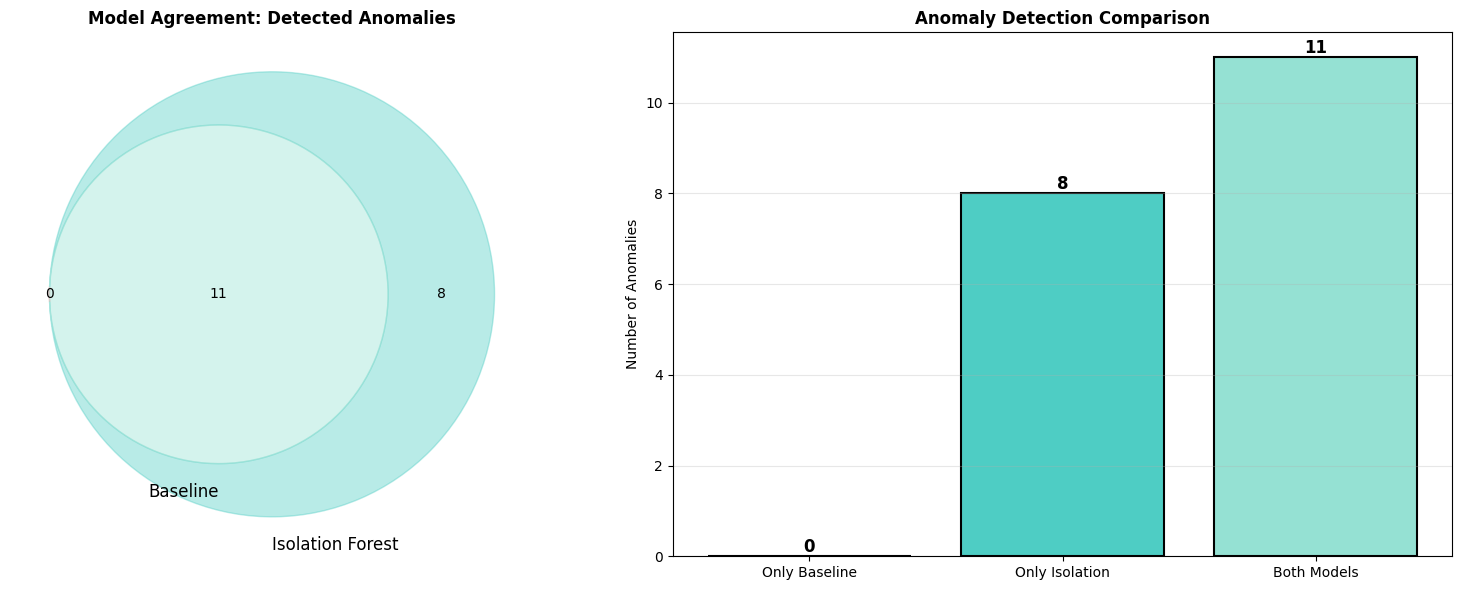

In [13]:
base_only_count = base_only.sum()
iso_only_count = iso_only.sum()
both_count = both.sum()
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

venn = venn2(
    subsets=(base_only_count, iso_only_count, both_count),
    set_labels=('Baseline', 'Isolation Forest'),
    ax=axes[0]
)

venn.get_patch_by_id('10').set_color('#FF6B6B')  # Baseline
venn.get_patch_by_id('01').set_color('#4ECDC4')  # Isolation
venn.get_patch_by_id('11').set_color('#95E1D3')  # Both

axes[0].set_title('Model Agreement: Detected Anomalies', fontweight='bold')

categories = ['Only Baseline', 'Only Isolation', 'Both Models']
counts = [base_only_count, iso_only_count, both_count]
colors = ['#FF6B6B', '#4ECDC4', '#95E1D3']

bars = axes[1].bar(categories, counts, color=colors, edgecolor='black', linewidth=1.5)
axes[1].set_ylabel('Number of Anomalies')
axes[1].set_title('Anomaly Detection Comparison', fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)

for bar in bars:
    height = bar.get_height()
    axes[1].text(
        bar.get_x() + bar.get_width()/2., height, f'{int(height)}', 
        ha='center', va='bottom', fontsize=12, fontweight='bold'
    )

plt.tight_layout()
plt.show()

### Silhouette Score (Isolation Forest)
---

In [14]:
if len(np.unique(pred_test_binary)) > 1:
    silhouette = silhouette_score(X_test, pred_test_binary)
    print(f"\nSilhouette Score: {silhouette:.4f}")
    print("Interpretation:", end=" ")
    if silhouette > 0.5:
        print("Excellent separation")
    elif silhouette > 0.2:
        print("Reasonable separation")
    else:
        print("Weak separation")
else:
    print("\nCannot calculate Silhouette (only 1 class detected)")


Silhouette Score: 0.5433
Interpretation: Excellent separation


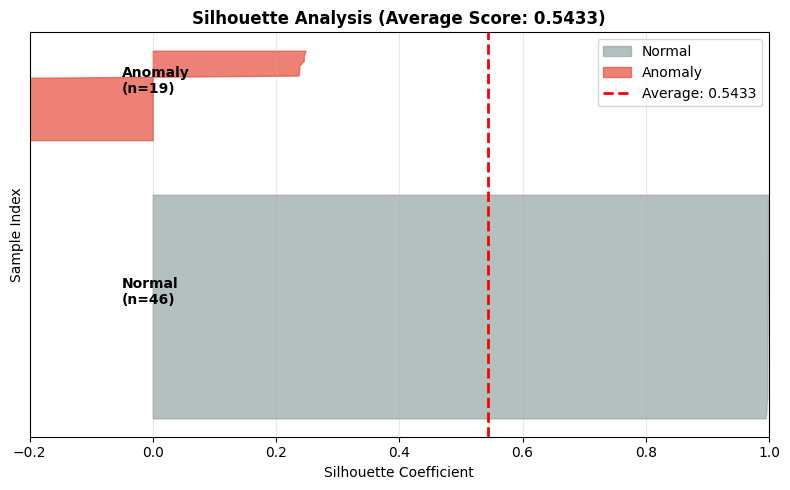

In [15]:
if len(np.unique(pred_test_binary)) > 1:
    silhouette_vals = silhouette_samples(X_test, pred_test_binary)
    silhouette_avg = silhouette_score(X_test, pred_test_binary)
    fig, ax = plt.subplots(figsize=(8, 5))
    y_lower = 10
    for i in [0, 1]:  # 0=normal, 1=anomaly
        cluster_silhouette_vals = silhouette_vals[pred_test_binary == i]
        cluster_silhouette_vals.sort()
        size_cluster = cluster_silhouette_vals.shape[0]
        y_upper = y_lower + size_cluster
        
        color = '#95A5A6' if i == 0 else '#E74C3C'
        label = 'Normal' if i == 0 else 'Anomaly'
        
        ax.fill_betweenx(
            np.arange(y_lower, y_upper), 0, cluster_silhouette_vals,
            facecolor=color, edgecolor=color, alpha=0.7, label=label
        )
        ax.text(
            -0.05, y_lower + 0.5 * size_cluster, f'{label}\n(n={size_cluster})',
            fontsize=10, fontweight='bold'
        )
        
        y_lower = y_upper + 10
    
    ax.set_xlabel('Silhouette Coefficient')
    ax.set_ylabel('Sample Index')
    ax.set_title(f'Silhouette Analysis (Average Score: {silhouette_avg:.4f})', fontweight='bold')
    ax.axvline(x=silhouette_avg, color='red', linestyle='--', linewidth=2, label=f'Average: {silhouette_avg:.4f}')
    ax.set_xlim([-0.2, 1])
    ax.set_yticks([])
    ax.legend(fontsize=10)
    ax.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.show()
else:
    print("Cannot plot Silhouette (only 1 class)")

### Conclusion
---
The Isolation Forest model consistently outperforms the baseline performance floor, detecting approximately 72.7% more anomalous events while maintaining good separation quality (average silhouette score ≈ 0.54). The high level of agreement between models (11 shared detections) indicates strong alignment on the most extreme cases, while the additional 8 anomalies identified exclusively by Isolation Forest highlight its ability to capture more subtle, multidimensional deviation patterns that fall outside simple univariate thresholds.

These results suggest that the two approaches are complementary rather than redundant. The baseline model remains effective at identifying clear statistical outliers with high confidence, whereas Isolation Forest extends detection coverage to structurally distinct but less obvious anomalies. For operational deployment, a tiered or hybrid detection strategy is recommended: events flagged by both models should be treated as high-priority alerts, while anomalies detected exclusively by Isolation Forest can be routed for secondary analysis or analyst review.